### Crop Recommendation (MLP)

In this notebook we are going to create a `Multi-Layer Perceptron (MLP)` model that will suggest to farmers which is the best crop to grow among `22` different crops based on different conditions:

- `N` - ratio of Nitrogen content in soil
- `P` - ratio of Phosphorous content in soil
- `K` - ratio of Potassium content in soil
- `temperature` - temperature in degree Celsius
- `humidity` - relative humidity in %
- `ph` - ph value of the soil
- `rainfall` - rainfall in mm

The dataset that is used for this task was found on [`Kaggle - Crop Recommendation Dataset`](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset)


In the following code cell we are going to install all the packages that we are going to use in this notebook.

In [1]:
!pip install helperfns kaggle pigmenta -q

In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [2]:
import warnings
import random
import os
import time
import json

import pandas as pd
import numpy as np
import seaborn as sns

from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from pigmenta import PALETTES

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)

pandas: 2.2.2
numpy: 2.0.2
torch: 2.6.0+cu124


### Seed
In the following code cell we are going to set the seed to all random operations for reproducivity.

In [3]:
SEED = 23
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get `gpu` device if possible

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data
Our dataset that we are going to use will be comming from kaggle. So we are going to download it using the `kaggle` api, in the code cells that follows.

> URL: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset

In [5]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']
!kaggle datasets download atharvaingle/crop-recommendation-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset
License(s): apache-2.0
  0% 0.00/63.7k [00:00<?, ?B/s]
100% 63.7k/63.7k [00:00<00:00, 128MB/s]


In the following code cell we are going to read the `csv` file and check the first `2` rows in the dataset.

In [6]:
dataframe = pd.read_csv("Crop_recommendation.csv")
dataframe.head(2)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice


In the following code cell we are going to drop null and na values from the dataframe if they exists.

In [7]:
if any(dataframe.isna().any()):
    dataframe.dropna(inplace=True)

In the following code cell we are going to check the unique crop names that we have in the dataset.

In [8]:
print(f"Unique Crops: {len(dataframe.label.unique())}")

Unique Crops: 22


### Data Insights

In the following code cell we are going to visualize the distribution of features in the dataset.

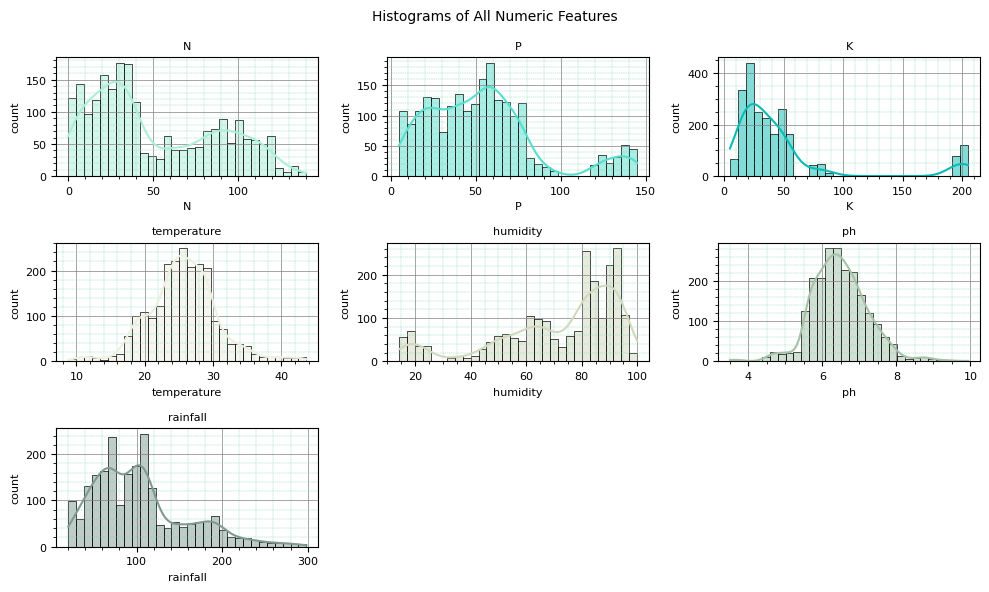

In [9]:
numeric_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
plt.figure(figsize=(10, 6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataframe[col], kde=True, bins=30, color=PALETTES.gradient[i])
    plt.title(col, fontsize=8)
    plt.xlabel(col, fontsize=8)
    plt.ylabel("count", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.suptitle("Histograms of All Numeric Features", fontsize=10)
plt.tight_layout()
plt.show()

In the following code cell we are then going to plot the pairplot of each numerical value with the respective label.

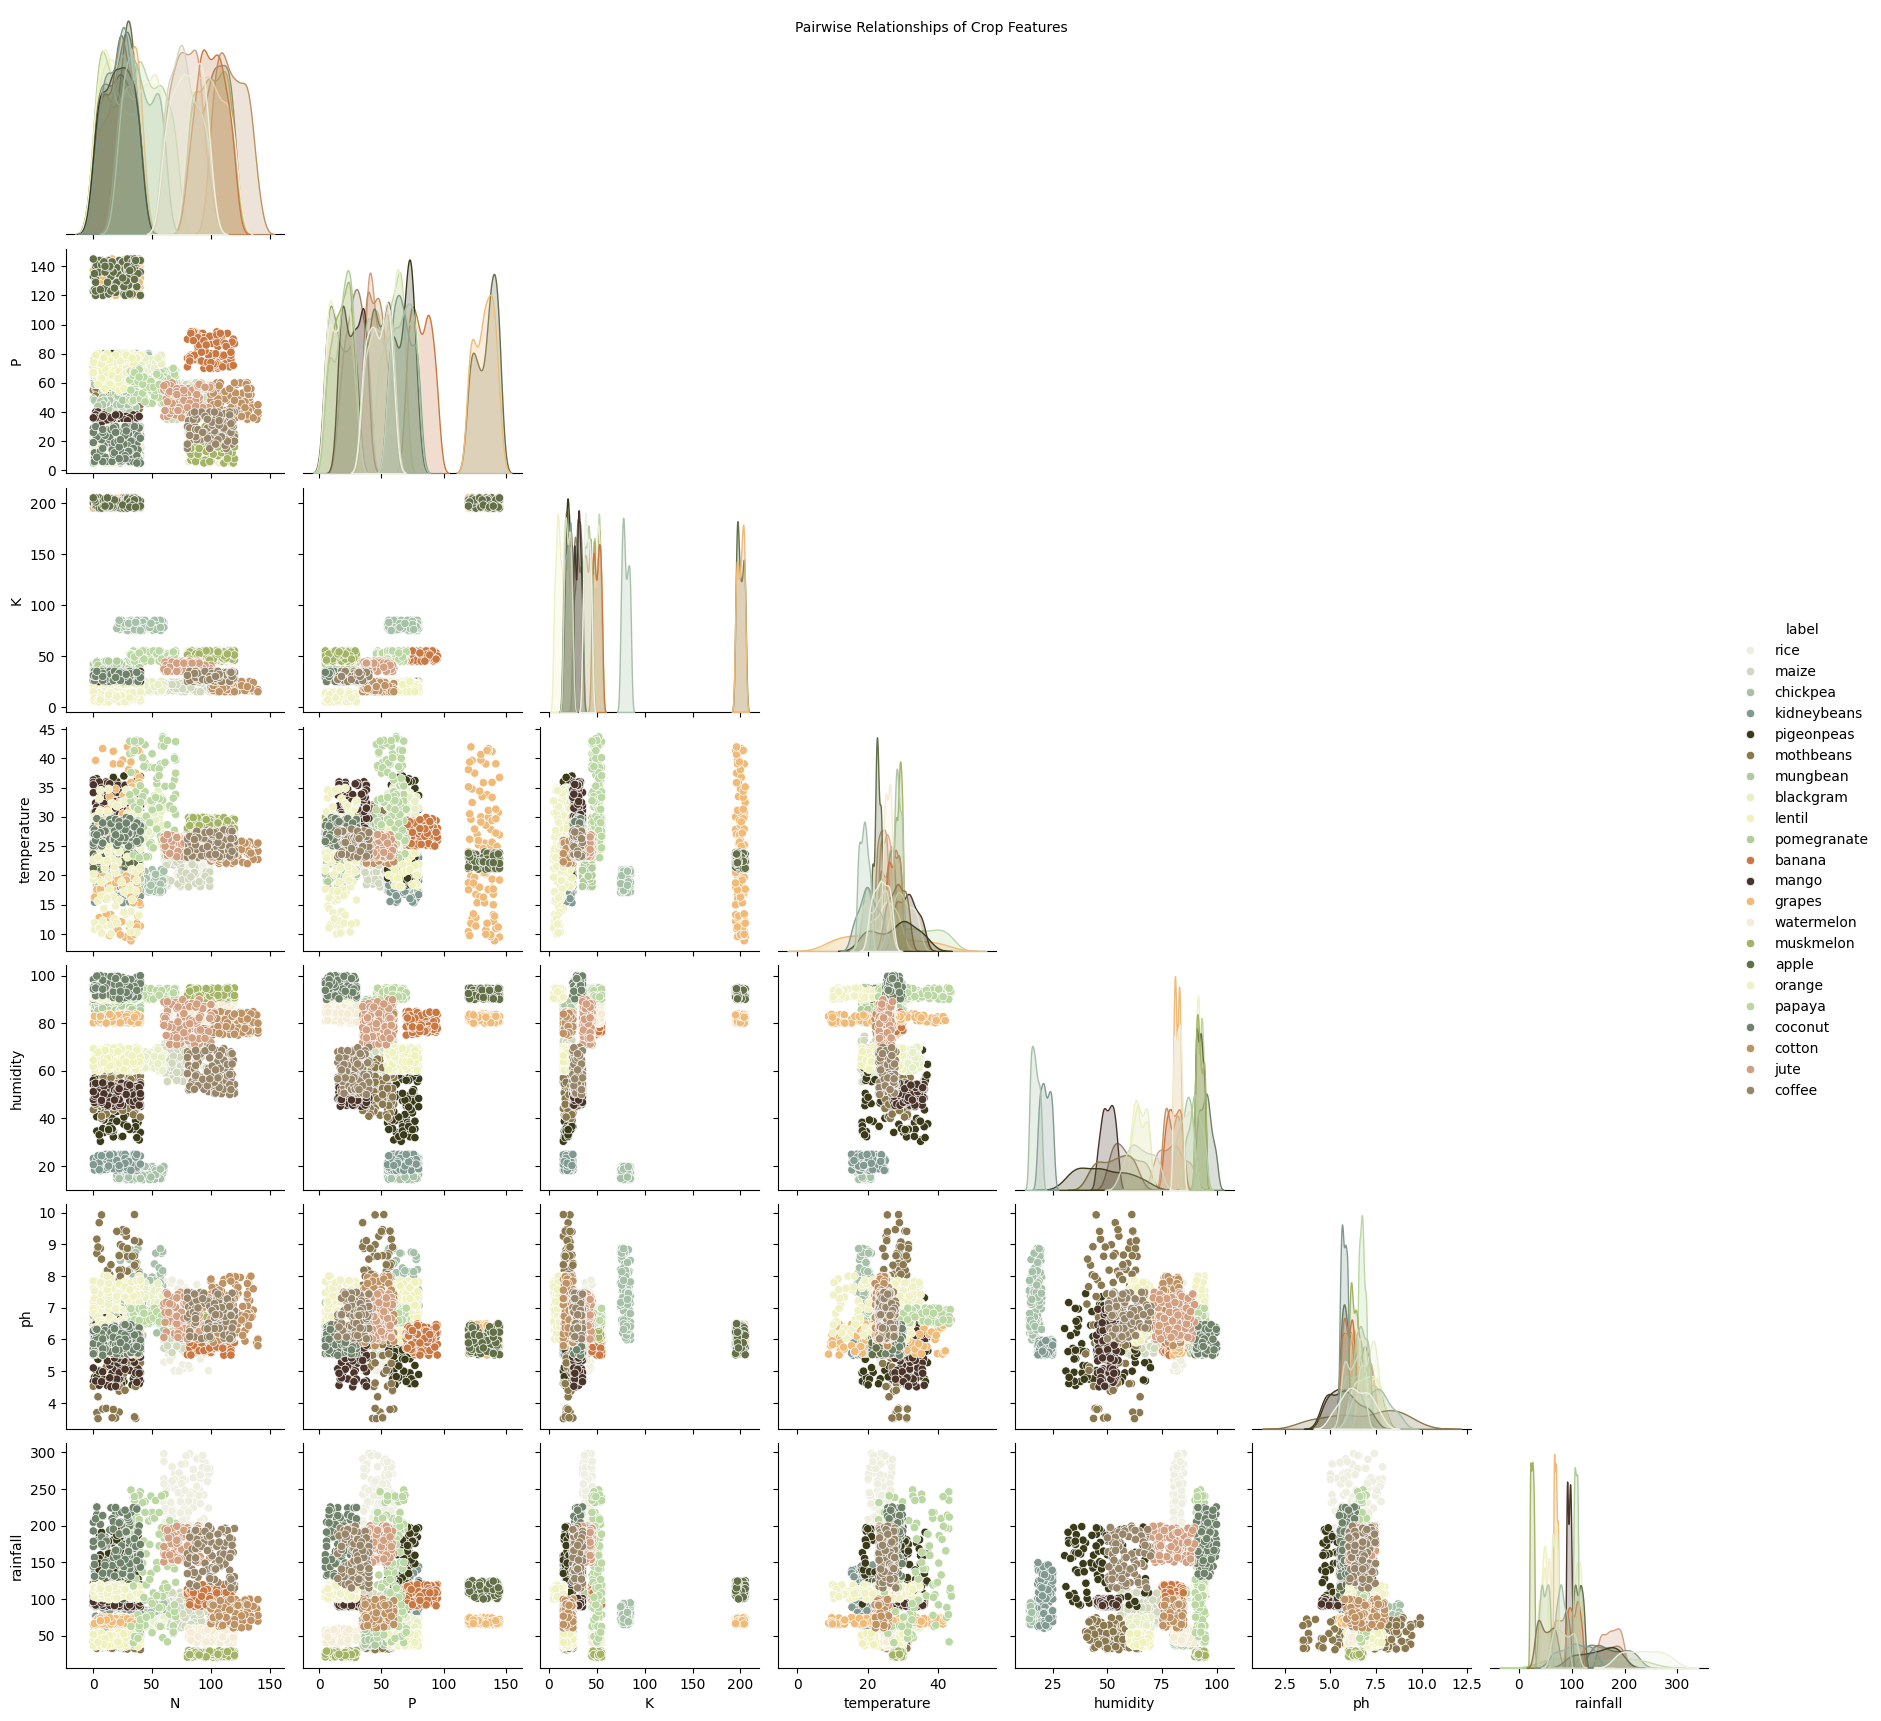

In [10]:
pair_plot = sns.pairplot(
    dataframe,
    hue='label',
    vars=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'],
    diag_kind='kde',
    palette=PALETTES.earth,
    corner=True
)

pair_plot.fig.suptitle("Pairwise Relationships of Crop Features", fontsize=10)
plt.show()

In the following code cell we are going to check how many unique labels we have in the dataset.

In [11]:
dataframe.label.value_counts()

,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


In the following code cell we are going to split the data into `train` and `test` sets.

In [12]:
train, test = train_test_split(dataframe, test_size=0.3, random_state=SEED)

In the following code cell we are going to visualize the examples in each set.

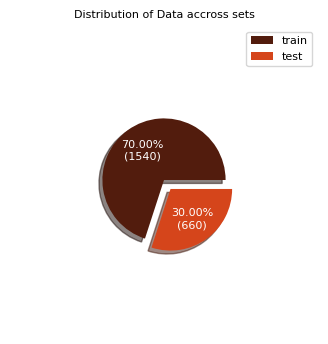

In [13]:
dist_sets = {'train': len(train), 'test': len(test)}
def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)
plt.figure(figsize=(4, 4))
plt.title("Distribution of Data accross sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(dataframe)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=PALETTES.fall, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

In the following code cell we are going to extract the features and labels for each set.

In [14]:
X_train = train.drop(columns=['label'])
y_train = train.label.values
X_test = test.drop(columns=['label'])
y_test = test.label.values
y_test[:2]

array(['mango', 'blackgram'], dtype=object)

In [15]:
X_train.head(2)

,N,P,K,temperature,humidity,ph,rainfall
1731,34,68,51,27.347349,94.177567,6.687088,40.351531
921,40,27,45,21.660250,94.793974,5.885638,112.434969


We are going to create the encoder object using the  `LabelEncoder` that will encode labels to numerical.

In [16]:
encoder = LabelEncoder()
def encode_labels(encoder, train, test):
    train = encoder.fit_transform(train.reshape(-1, 1))
    return train.reshape(-1), encoder.transform(test.reshape(-1, 1)).reshape(-1)

train_crops, test_crops = encode_labels(encoder, y_train, y_test)

In the following code cell we are going to check some examples of transformed labels to see if the transformation was successful.

In [17]:
train_crops[:2], y_train[:2], encoder.inverse_transform(train_crops[:2])

(array([17, 19]),
 array(['papaya', 'pomegranate'], dtype=object),
 array(['papaya', 'pomegranate'], dtype=object))

In the following code cell we are going to transform the features by scaling them using a standard scaler.

In [18]:
num_features = X_train.columns

scale_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("scale pre-processing", scale_pipeline, num_features)
])

train_features = ct.fit_transform(X_train)
test_features = ct.transform(X_test)

In the following code cell we are going to check a sigle feature from the training features.

In [19]:
train_features[0]

array([-0.46125222,  0.45711947,  0.06053586,  0.35226001,  1.01561816,
        0.28073336, -1.13158519])

In the following code cell we are going to create the dataset using the `TensorDataset` class. After that we are going to batch the dataset using a batch size of `4` using the `DataLoader` class

In [20]:
trainset = TensorDataset(
    torch.from_numpy(train_features).float(), torch.from_numpy(train_crops)
)
testset = TensorDataset(
    torch.from_numpy(test_features).float(), torch.from_numpy(test_crops)
)

BATCH_SIZE = 4

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In the following code cell we are going to create check a single example of training data.

In [21]:
example = next(iter(trainloader))
example[0], example[1]

(tensor([[ 2.2739, -0.5168, -0.4771, -0.5743,  0.3947,  1.4695, -0.2357],
         [ 0.2896,  0.1832, -0.1386, -0.2763,  0.1458,  0.9178,  1.6096],
         [ 1.0404, -0.2734, -0.1983, -0.3547,  0.5513,  1.3068,  2.4872],
         [ 1.1745, -1.1256,  0.1402, -0.0660,  0.7167,  0.1838, -1.1356]]),
 tensor([ 6,  8, 20, 21]))

### Creating a Model (MLP)

We are going to use a Linear layers to create a `Multi-layer Perceptron (MLP)` model that does the classification of the perfect crop to grow given the soil conditions.

In [22]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=.5):
    super(MLP, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 16),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(16, output_dim)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    x = self.classifier(x)
    return x

In the following code cell we are going to create the instance of our model.

In [23]:
input_dim = test_features.shape[1]
output_dim = 1 if len(encoder.classes_) == 2 else len(encoder.classes_)
mlp = MLP(input_dim=len(X_train.columns), output_dim=len(encoder.classes_), dropout=.11).to(device)
mlp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.11, inplace=False)
    (3): Linear(in_features=128, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.11, inplace=False)
    (6): Linear(in_features=16, out_features=22, bias=True)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [24]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return total_params, trainable_params

total_params, trainable_params = count_params(mlp)

tabulate_data(["","Total Parameters", "Trainable Parameteres"],
           [["MLP", f'{total_params:,}', f'{trainable_params:,}']],
           "MODEL PARAMETERS")

MODEL PARAMETERS
+-----+------------------+-----------------------+
|     | Total Parameters | Trainable Parameteres |
+-----+------------------+-----------------------+
| MLP |            3,462 |                 3,462 |
+-----+------------------+-----------------------+


### Optimizer and Criterion
In the following code cell we are going to define the `optimizer` and `criterion`. For the optimizer we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [25]:
optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the `predicted` labels and `real` labels.

In [26]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions:

In [27]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).long()
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).long()
      y_pred = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training History

When training the model we are going to  keep on tracking the training history of the model. The following `History` class is a data structure for our training history.

In [28]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### Training Loop
In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [29]:
EPOCHS = 40
def train_model(model, model_name, train_iterator, optimizer, criterion, device, valid_iterator):
  best_valid_loss = float('inf')
  column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
  last_saved_epoch = 1

  history = History()
  training_start = time.time()
  for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      save_status = "(saving)"
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), model_name)

    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


    data_rows = [
        ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
    ]

    title = f"{model_name.replace('.pt', '')}: EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    tabulate_data(column_names, data_rows, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [30]:
history, training_end, last_saved_epoch = train_model(
    mlp, 'mlp.pt', trainloader, optimizer, criterion, device, testloader
)

mlp: EPOCH 01/40: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 2.293 |   32.27% | 0:00:00.79 |
| Validation | 1.240 |   69.39% |            |
+------------+-------+----------+------------+
mlp: EPOCH 02/40: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.959 |   69.16% | 0:00:01.01 |
| Validation | 0.546 |   85.61% |            |
+------------+-------+----------+------------+
mlp: EPOCH 03/40: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.637 |   76.88% | 0:00:00.77 |
| Validation | 0.352 |   90.76% |            |
+------------+-------+----------+------------+
mlp: EPOCH 04/40: (saving)
+------------+-------+----------+------------+

In the following code cell we are going to visualize the model's training history and last saved epoch.

In [31]:
rows = [
      ["MLP", f'{EPOCHS}', f'{last_saved_epoch}', f'{hms_string(training_end)}']
]
tabulate_data(['MODEL', 'TOTAL EPOCHS', "LAST SAVED EPOCH", "TOTAL TRAINING TIME (s)"],
              rows, "MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH
+-------+--------------+------------------+-------------------------+
| MODEL | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME (s) |
+-------+--------------+------------------+-------------------------+
| MLP   |           40 |               37 |              0:00:31.96 |
+-------+--------------+------------------+-------------------------+


### Training History
In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

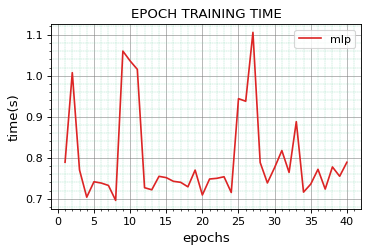

In [32]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color=PALETTES.christmas[1], label='mlp')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for the model that was observed during model training.

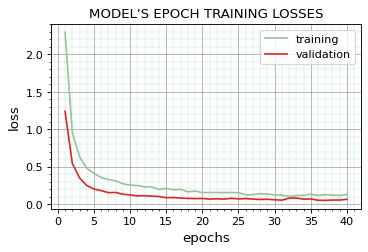

In [33]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color=PALETTES.christmas[0], label='training')
plt.plot(epochs, history.val_losses, color=PALETTES.christmas[1], label='validation')
plt.title("MODEL'S EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

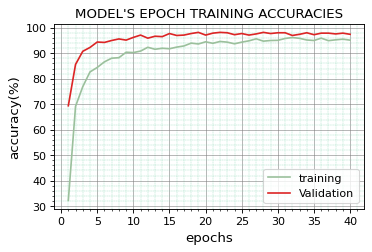

In [34]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color=PALETTES.christmas[0], label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color=PALETTES.christmas[1], label='Validation')

plt.title("MODEL'S EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [35]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
mlp.load_state_dict(torch.load('mlp.pt'))
test_loss, test_acc = evaluate(mlp, testloader, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]
tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.051 |   97.88% |            |
+------+-------+----------+------------+


### Model Inference

In this section of the notebook we are going to make prediction based on the user input using the best save model.

In [36]:
test.head(2)

,N,P,K,temperature,humidity,ph,rainfall,label
1158,11,34,32,29.143050,49.409833,6.831707,97.551555,mango
791,59,58,17,28.546224,66.313941,7.368319,62.834699,blackgram


Predicting `mango` crop.

In [37]:
details = { "N": 11, "P": 23, "K": 32, "temperature": 29.143050, "humidity": 49.409833, "ph": 6.831707, "rainfall": 97.551555 }

def recommend_crop(details, model, device):
  features = pd.DataFrame([details])[num_features]
  features = ct.transform(features)
  features = torch.from_numpy(features).float()
  model.eval()
  with torch.no_grad():
    features = features.to(device)
    y_pred = model(features)
    probabilities = torch.softmax(y_pred.squeeze(), dim=0)
    label = probabilities.argmax(0).item()
    top = {
        "crop": encoder.classes_[label],
        "probability": float(probabilities[label]),
        "label": label
    }
    predictions = [{
        "crop": encoder.classes_[i],
        "probability": float(prob),
        "label": i
    } for i, prob in enumerate(probabilities)]
    return {"top": top, "predictions": predictions}

recommend_crop(details, mlp, device)

{'top': {'crop': 'mango', 'probability': 0.9988034963607788, 'label': 12},
 'predictions': [{'crop': 'apple',
   'probability': 7.129838699695927e-20,
   'label': 0},
  {'crop': 'banana', 'probability': 7.58518007901297e-22, 'label': 1},
  {'crop': 'blackgram', 'probability': 5.557045709009278e-13, 'label': 2},
  {'crop': 'chickpea', 'probability': 1.7968524446132506e-09, 'label': 3},
  {'crop': 'coconut', 'probability': 1.1370739419480635e-12, 'label': 4},
  {'crop': 'coffee', 'probability': 8.182558630664971e-09, 'label': 5},
  {'crop': 'cotton', 'probability': 2.6671908132691363e-16, 'label': 6},
  {'crop': 'grapes', 'probability': 4.6620168041067394e-23, 'label': 7},
  {'crop': 'jute', 'probability': 6.599332209589193e-07, 'label': 8},
  {'crop': 'kidneybeans', 'probability': 6.990267920059523e-09, 'label': 9},
  {'crop': 'lentil', 'probability': 2.155052776381676e-15, 'label': 10},
  {'crop': 'maize', 'probability': 2.8567984600158525e-07, 'label': 11},
  {'crop': 'mango', 'probab

Predicting `blackgram` crop.

In [38]:
details = { "N": 59, "P": 58, "K": 17, "temperature": 28.546224, "humidity": 66.313941, "ph": 7.368319, "rainfall": 62.834699 }
recommend_crop(details, mlp, device)

{'top': {'crop': 'blackgram', 'probability': 0.9980060458183289, 'label': 2},
 'predictions': [{'crop': 'apple',
   'probability': 1.4671927091464663e-20,
   'label': 0},
  {'crop': 'banana', 'probability': 2.2452278615947216e-14, 'label': 1},
  {'crop': 'blackgram', 'probability': 0.9980060458183289, 'label': 2},
  {'crop': 'chickpea', 'probability': 8.76833165536911e-13, 'label': 3},
  {'crop': 'coconut', 'probability': 3.069446654041085e-15, 'label': 4},
  {'crop': 'coffee', 'probability': 3.1219710082816467e-16, 'label': 5},
  {'crop': 'cotton', 'probability': 4.106745521426092e-08, 'label': 6},
  {'crop': 'grapes', 'probability': 1.7013447942137994e-11, 'label': 7},
  {'crop': 'jute', 'probability': 1.1804713456742277e-11, 'label': 8},
  {'crop': 'kidneybeans', 'probability': 2.3023137174504882e-08, 'label': 9},
  {'crop': 'lentil', 'probability': 0.0012327719014137983, 'label': 10},
  {'crop': 'maize', 'probability': 0.0007042994839139283, 'label': 11},
  {'crop': 'mango', 'proba

### Saving Objects

In the following code cell we are going to save all the objects that we are going to use for inference.

In [39]:
dump({
    "model": num_features,
    "column_transformer": ct,
    "encoder": encoder
}, "crop_recommendation_bundle.joblib")
print("Done!")

Done!
